# Imports

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm

# Config

In [27]:
class CFG:
    seed = 888
    debug = False
    one_fold = False
    base_dir = pathlib.Path(".")
    path_train = base_dir / "train.csv"
    spec_dir =  "EEG_Spectrograms"
    transform = transforms.Resize((768, 768), antialias=False)
    model_name = "tf_efficientnet_b0.ns_jft_in1k"
    n_fold = 5
    epochs = 10
    batch_size = 8
    lr = 0.0001  
    smooth = 0

# Load data
- We classify the spectrogram directly.
- As a label we use the aggregated the votes per spectrogram slice

In [4]:
train_df = pd.read_csv("updated_train.csv")
print('Train shape:', train_df.shape )

train_df['total_evaluators'] = train_df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
train_df = train_df[train_df.total_evaluators>=10].reset_index(drop=True)
del train_df['total_evaluators']
train_df

Train shape: (100784, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5
1,2277392603,1,2.0,924234,1,2.0,134339127,30539,GPD,0,0,5,0,1,5
2,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0,1,0,14,0,1
3,722738444,1,2.0,999431,1,2.0,1949834128,56885,LRDA,0,1,0,14,0,1
4,722738444,2,4.0,999431,2,4.0,3790867376,56885,LRDA,0,1,0,14,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38077,2750557840,2,10.0,2146188334,2,10.0,621803104,21884,Other,0,0,0,0,0,13
38078,3910994355,0,0.0,2146798838,0,0.0,4272062867,28488,LPD,0,9,0,2,0,7
38079,3938393892,0,0.0,2146798838,1,60.0,2587113091,28488,LPD,0,9,0,2,0,7
38080,3938393892,1,4.0,2146798838,2,64.0,827904671,28488,LPD,0,9,0,2,0,7


In [5]:
label_columns = train_df.filter(like="_vote").columns.to_list()
label_columns

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [7]:
PATH = 'E:/HMS2024/train_spec_for_paper/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')
import pickle
def picklesave(obj,file):
    ff = open(file,'wb')
    pickle.dump(obj,ff)
    ff.close()

def pickleload(file):
    ff = open(file,'rb')
    obj = pickle.load(ff)
    ff.close()
    return obj


spectrograms = pickleload('specs.pkl')

There are 10428 spectrogram parquets


In [9]:
TARGETS = train_df.columns[-6:]
data = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
data.columns = ['spec_id','min']

tmp = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
data['max'] = tmp

tmp = train_df.groupby('eeg_id')[['patient_id']].agg('first')
data['patient_id'] = tmp

tmp = train_df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    data[t] = tmp[t].values
    
y_data = data[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
data[TARGETS] = y_data

tmp = train_df.groupby('eeg_id')[['expert_consensus']].agg('first')
data['target'] = tmp

data = data.reset_index()
print('Train non-overlapp eeg_id shape:', data.shape )
data["path"] = data.eeg_id.map(lambda x: f"EEG_Spectrograms/{x}.npy")

data.head()

Train non-overlapp eeg_id shape: (5599, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,path
0,568657,789577333,0.0,16.0,20654,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,Other,EEG_Spectrograms/568657.npy
1,582999,1552638400,0.0,38.0,20230,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,LPD,EEG_Spectrograms/582999.npy
2,1895581,128369999,1138.0,1138.0,47999,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,Other,EEG_Spectrograms/1895581.npy
3,2482631,978166025,1902.0,1944.0,20606,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,Other,EEG_Spectrograms/2482631.npy
4,2521897,673742515,0.0,4.0,62117,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,Other,EEG_Spectrograms/2521897.npy


# Data Handling
- Spectrogram is loaded, which contains spectrograms in 4 different regions.
- All together they are clipped, log-transformed and the standardized.
- Finally it is resized as an image.
- Note, since the spectrograms have sometimes very different lenghts this creates a certain distortion.

In [12]:
from torch.utils.data import Dataset, DataLoader
def preprocess(x):
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x

def preprocess2(x):
    x = np.clip(x, np.exp(-6), np.exp(10))
    x = np.log(x)
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x

In [13]:
class SpecDataset(Dataset):
    
    def __init__(self, df, transform=CFG.transform, mode='train'):
        self.df = df
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        # input
        x = np.load(row.path)
        x = [x[:,:,i+0:i+1] for i in range(6)]
        x1 = np.concatenate(x,axis=0)[:,:,0]

        x1 = preprocess(x1)
        x = spectrograms[row.spec_id]
        r = int( (row['min'] + row['max'])//4 )
        x = x[:,r:r+300]

        x2 = preprocess2(x)
        x2 = torch.Tensor(x2[None, :])
        x2 = np.array(CFG.transform(x2))[0]

        x = np.concatenate([x1,x2])

        
        x = torch.Tensor(x[None, :])
        if self.transform:
            x = self.transform(x)
        # output
        y = np.array(row.loc[label_columns].values, 'float32')
        
        if CFG.smooth and self.mode!='valid':
            factor = 0.05
            y = y * (1 - factor)
            y = y + (factor / 6)
        
        y = torch.Tensor(y)
        return x, y

# Model

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model(model_name=CFG.model_name, pretrained=False, num_classes=6, in_chans=1)
model.to(DEVICE)

tensor([[-5.0011e-01,  1.8929e-01, -1.6941e+00,  2.0233e-01, -1.8864e-01,
          5.6967e-03],
        [-5.9857e-01,  7.4707e-01, -1.6459e+00,  2.5856e-01,  1.9623e-02,
          3.5523e-02],
        [-4.9668e+00,  2.0073e+00, -2.0812e+00,  1.1825e+00, -2.7803e-01,
          8.9545e-01],
        [-1.4151e+00,  9.4726e-01, -1.9046e+00,  4.0096e-01, -4.2966e-02,
          1.8834e-01],
        [ 7.2708e-01,  4.5894e-01, -1.0595e+00, -3.7439e-01, -9.5965e-02,
         -4.6204e-01],
        [-3.4622e+00,  1.5494e+00, -2.4683e+00,  9.5744e-01,  1.0669e-01,
          1.7129e-01],
        [-1.3635e+00,  7.5871e-01, -1.8120e+00,  1.6089e-01,  4.9499e-02,
         -1.3671e-01],
        [-1.3698e+01,  5.4834e+00, -2.8801e+00,  2.4018e+00,  1.4196e+00,
         -1.9433e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [23]:
def KLDivLoss(logit, target):
    log_prob = F.log_softmax(logit, dim=1)
    return F.kl_div(log_prob, target, reduction="batchmean")

def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

def compute_loss(model, data_loader):
    model.eval()
    l_loss = []
    with torch.no_grad():
        for x, y in data_loader:
            y_pred = model(x.to(DEVICE))
            loss = KLDivLoss(y_pred, y.to(DEVICE))
            l_loss.append(loss.item())
    return np.mean(l_loss) 

In [25]:
from sklearn.model_selection import KFold
if CFG.debug:
    data = data.iloc[:400]

Fold 0:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.292613, Valid Loss:   0.250242
Loss improves from        inf to   0.250242


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.247733, Valid Loss:   0.242987
Loss improves from   0.250242 to   0.242987


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.224723, Valid Loss:   0.237057
Loss improves from   0.242987 to   0.237057


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.200110, Valid Loss:   0.236217
Loss improves from   0.237057 to   0.236217


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.182524, Valid Loss:   0.231823
Loss improves from   0.236217 to   0.231823


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.163264, Valid Loss:   0.242495


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.143736, Valid Loss:   0.247022


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.125779, Valid Loss:    0.24678


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.111335, Valid Loss:   0.246757


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.099962, Valid Loss:   0.261418

Best loss Model training with 0.23182260074785777



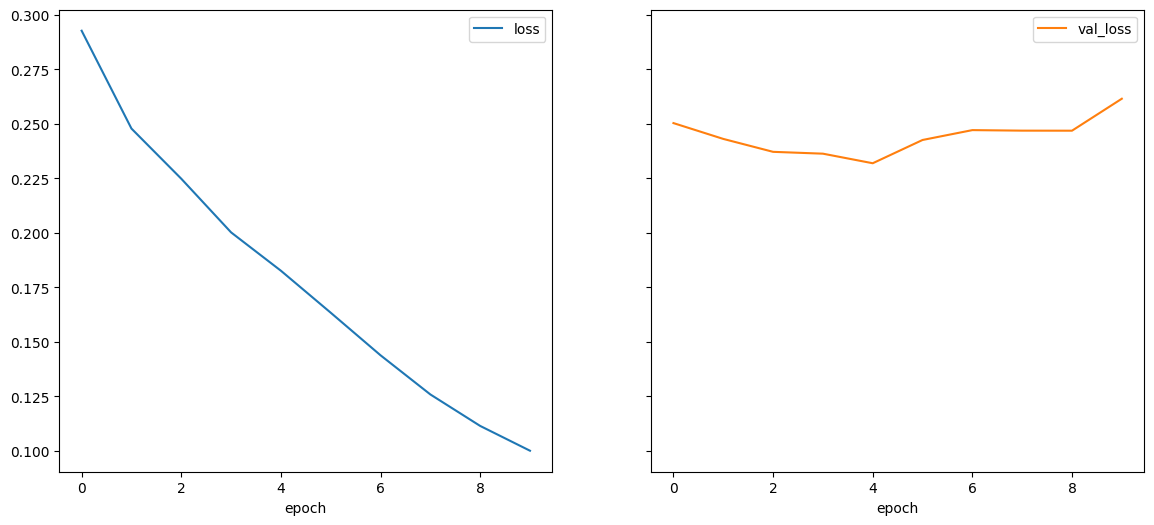

Fold 1:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.286703, Valid Loss:   0.261499
Loss improves from        inf to   0.261499


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.239733, Valid Loss:   0.249995
Loss improves from   0.261499 to   0.249995


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.215744, Valid Loss:   0.248454
Loss improves from   0.249995 to   0.248454


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.196128, Valid Loss:   0.251636


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.170849, Valid Loss:   0.255866


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.149503, Valid Loss:   0.259039


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.130574, Valid Loss:   0.254756


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.114426, Valid Loss:   0.253721


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.100748, Valid Loss:   0.262105


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.088319, Valid Loss:   0.265794

Best loss Model training with 0.24845395780035429



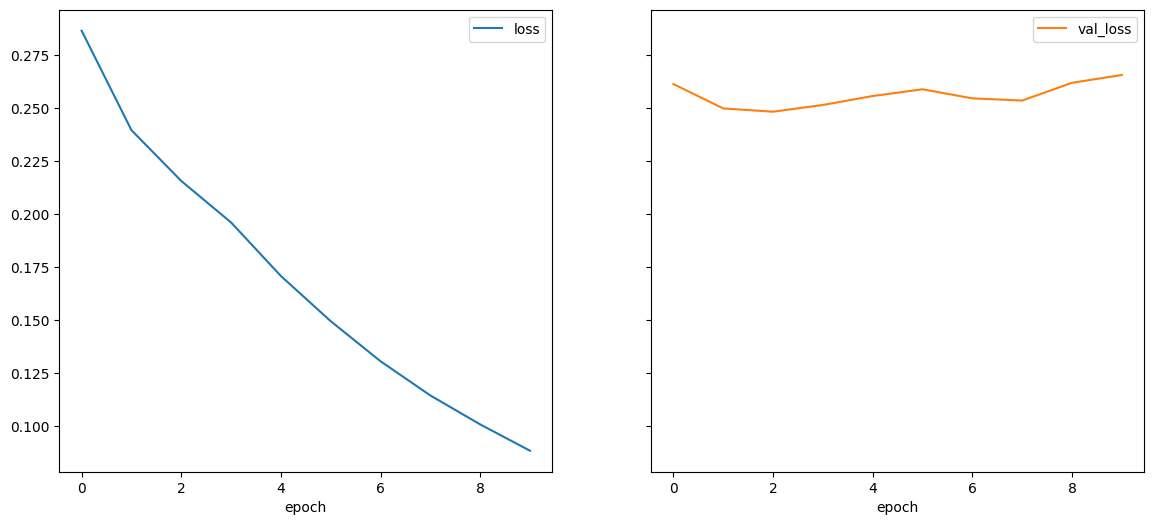

Fold 2:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.278994, Valid Loss:   0.242282
Loss improves from        inf to   0.242282


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.233301, Valid Loss:   0.227291
Loss improves from   0.242282 to   0.227291


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.212146, Valid Loss:   0.228871


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.192674, Valid Loss:   0.221695
Loss improves from   0.227291 to   0.221695


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.173961, Valid Loss:   0.224093


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.153747, Valid Loss:    0.22249


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.135322, Valid Loss:   0.232623


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.118099, Valid Loss:   0.234957


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.105311, Valid Loss:   0.237457


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.092299, Valid Loss:   0.238091

Best loss Model training with 0.22169482175792968



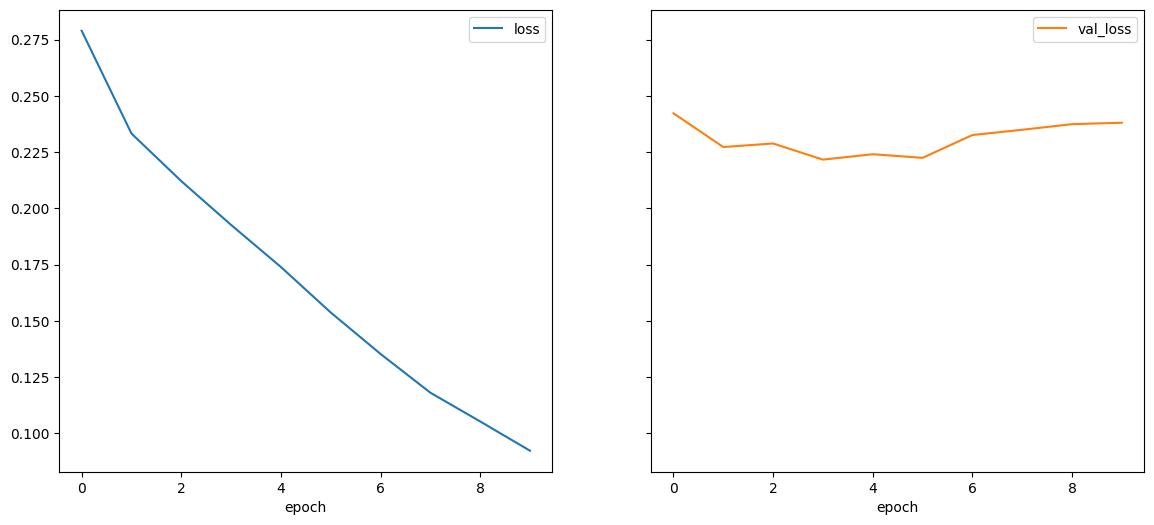

Fold 3:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.281975, Valid Loss:   0.219198
Loss improves from        inf to   0.219198


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.241576, Valid Loss:   0.220088


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.219176, Valid Loss:   0.217451
Loss improves from   0.219198 to   0.217451


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.196165, Valid Loss:   0.217375
Loss improves from   0.217451 to   0.217375


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.177421, Valid Loss:   0.220078


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.157949, Valid Loss:   0.220632


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.138035, Valid Loss:   0.227742


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.122720, Valid Loss:   0.246834


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.108878, Valid Loss:   0.238401


  0%|          | 0/559 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.096617, Valid Loss:   0.239214

Best loss Model training with 0.21737470664083958



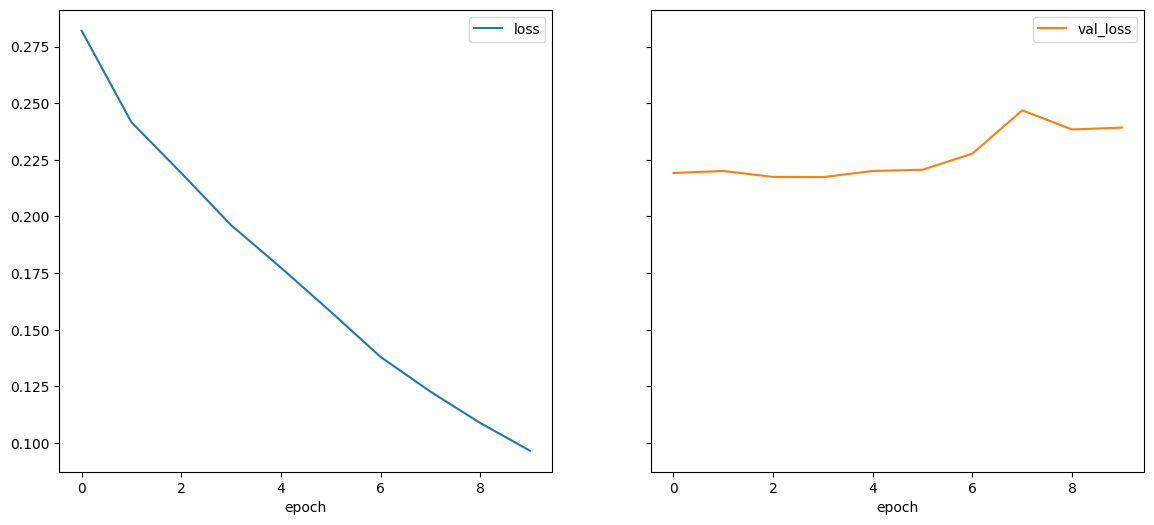

Fold 4:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.261878, Valid Loss:   0.245989
Loss improves from        inf to   0.245989


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.221619, Valid Loss:   0.237525
Loss improves from   0.245989 to   0.237525


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.204710, Valid Loss:   0.239837


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.184716, Valid Loss:   0.233138
Loss improves from   0.237525 to   0.233138


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.168130, Valid Loss:   0.239331


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.152678, Valid Loss:   0.245117


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.138387, Valid Loss:   0.252168


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.123570, Valid Loss:   0.251131


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.109281, Valid Loss:   0.253697


  0%|          | 0/560 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.100244, Valid Loss:   0.258435

Best loss Model training with 0.23313842011349542



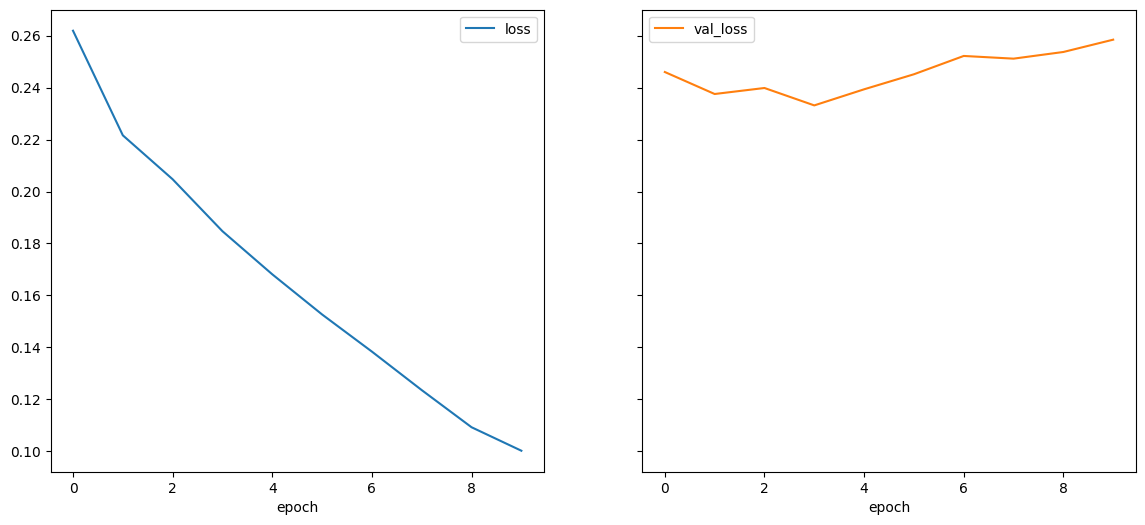

CPU times: total: 13h 32min 24s
Wall time: 5h 7min 34s


In [28]:
%%time

kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

l_best_loss = []
for fold, (iloc_train, iloc_valid) in enumerate(kf.split(data)):
    print(f"Fold {fold}:")
    
    train_ds = SpecDataset(df=data.iloc[iloc_train])
    valid_ds = SpecDataset(df=data.iloc[iloc_valid], mode='valid')
    train_loader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=0, drop_last=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=CFG.batch_size, num_workers=0)
    
    model = timm.create_model(model_name=CFG.model_name, pretrained=False, num_classes=6, in_chans=1)
    model.to(DEVICE)
    model.load_state_dict(torch.load(f'{CFG.model_name}_{fold}.pt'))
    
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG.epochs)
    optimizer, scheduler
    best_loss = float("inf")
    history = []

    for epoch in tqdm(range(CFG.epochs)):
        model.train()
        l_loss = []
        for x, y in tqdm(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)
            loss = KLDivLoss(y_pred, y)
            l_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss = np.mean(l_loss)
        valid_loss = compute_loss(model, valid_loader)
        history.append((epoch, train_loss, valid_loss))
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:>10.6f}, Valid Loss: {valid_loss:>10.6}")
        if valid_loss < best_loss:
            print(f"Loss improves from {best_loss:>10.6f} to {valid_loss:>10.6}")
            torch.save(model.state_dict(), f"{CFG.model_name}_{fold}_v2.pt")
            best_loss = valid_loss
    print(f"\nBest loss Model training with {best_loss}\n")
    l_best_loss.append(best_loss)
    
    history = pd.DataFrame(history, columns=["epoch", "loss", "val_loss"]).set_index("epoch")
    history.plot(subplots=True, layout=(1, 2), sharey="row", figsize=(14, 6))
    plt.show()
    
    if CFG.one_fold:
        break